# Big Data in Finance Assignment - Group 11

### Ahamad Hussein Ismail, Andres Brito Barreiro, Tianyu Yin, Yan Le, Zihao Han

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
# %pip install tabulate
from tabulate import tabulate

In [2]:
flow          = pd.read_excel('./Flows_Clean.xlsx')
tickers       = pd.read_excel('./PERMNO_Tickers.xlsx')
returns       = pd.read_excel('./Returns_Clean.xlsx')
flow.Dates    = pd.to_datetime(flow.Dates, format = '%Y%m%d')
returns.Dates = pd.to_datetime(returns.Dates, format = '%Y%m%d')
tickers.Dates = pd.to_datetime(tickers.Dates, format = '%Y%m%d')
permno=returns.columns.tolist()[1:]

# Warmup

In [3]:
# define the number of lags
lags = 3

# create an empty data frame with columns dates, permno, returns, and returns/flows number of lags
col_list = ['Dates','Permno','Return'] + [f'Return_{x+1}' for x in range(lags)] + [f'Flow_{x+1}' for x in range(lags)]
df = pd.DataFrame(columns = col_list)

# creates a dataframe of returns/flows and their lags for each company in permno
# print(comp_lags) to visualize
# stacks each dataframe underneath one another and puts it into the empty data dataframe
for company in permno:
    comp_lags = pd.DataFrame(columns = col_list)
    comp_lags['Dates']  = returns['Dates']
    comp_lags['Permno'] = company
    comp_lags['Return'] = returns[company]
    
    for i in range(lags):
        comp_lags['Return_'+str(i+1)] = comp_lags['Return'].shift(i+1)
        
    for i in range(lags):
        comp_lags['Flow_'+str(i+1)] = flow[company].shift(i+1)      
        
    df = pd.concat([df,comp_lags])

# drops the na values from the data dataframe
df = df.dropna()
df

,Dates,Permno,Return,Return_1,Return_2,Return_3,Flow_1,Flow_2,Flow_3
3,1993-04-06,55976,-0.067227,-0.024590,-0.020080,-0.019685,-5.642141,-6.975709,-4.696503
4,1993-04-07,55976,0.000000,-0.067227,-0.024590,-0.020080,-6.975709,-5.642141,-6.975709
5,1993-04-08,55976,0.040541,0.000000,-0.067227,-0.024590,-6.975709,-6.975709,-5.642141
6,1993-04-12,55976,0.038961,0.040541,0.000000,-0.067227,-6.975709,-6.975709,-6.975709
7,1993-04-13,55976,-0.033333,0.038961,0.040541,0.000000,-3.351631,-6.975709,-6.975709
...,...,...,...,...,...,...,...,...,...
1953,2000-12-22,48725,0.026415,0.037859,-0.030380,0.066127,5.569106,-3.791130,7.960677
1954,2000-12-26,48725,0.003676,0.026415,0.037859,-0.030380,5.934239,5.569106,-3.791130
1955,2000-12-27,48725,0.028083,0.003676,0.026415,0.037859,-1.281796,5.934239,5.569106
1956,2000-12-28,48725,-0.040380,0.028083,0.003676,0.026415,3.428868,-1.281796,5.934239


In [4]:
# splitting the the results from the variables and defining x and y
features = df.loc[:,'Return_1':'Flow_3'].values
outcome  = df.loc[:,'Return'].values


In [5]:
def calculate_metrics(y_true, y_pred):
    results = []
    results.append(metrics.mean_squared_error(y_true, y_pred))
    results.append(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    return results

In [6]:
def draw_distributions(results,num):   
    for i in range(len(results.columns)):
        ax = plt.subplot(num, 1, i+1)
        ax.hist(results.iloc[:,i], bins = 100)
        ax.set_title(results.columns.tolist()[i])

In [7]:
stocks = {}
for company in permno:
    data        = df.loc[df['Permno'] == company]
    stocks[company] = data.dropna()

In [8]:
def window_size(stocks, w, model):
    results = pd.DataFrame(columns=['mse_reg', 'rmse_reg','mse_mean','rmse_mean'])
    
    outcome_list = outcome[w:len(outcome)]
    window_length = w
    for company in list(stocks.keys()):
        prediction_list = []
        mean_list = []
        outcome_list = stocks[company].Return[w:]
        for i in range(w, 1955):
            train_feat = features[i-window_length:i]
            train_outcome = outcome[i-window_length:i]
            #historical mean
            mean_list.append(train_outcome.mean())
            
            regressor = model()
            regressor.fit(train_feat,train_outcome)
            # prediction
            y_pred = regressor.predict(features[[i]])
            prediction_list.append(y_pred[0]) 

        results.loc[len(results)] = (calculate_metrics(outcome_list, prediction_list) +
                                    calculate_metrics(outcome_list, mean_list))
    return results
      
    
results = window_size(stocks, 252, LinearRegression) # window size = 252 trading days per year
results

,mse_reg,rmse_reg,mse_mean,rmse_mean
0,0.000514,0.022677,0.000498,0.022318
1,0.000281,0.016772,0.000273,0.016526
2,0.000323,0.017981,0.000318,0.017820
3,0.000563,0.023723,0.000557,0.023602
4,0.003136,0.056002,0.003128,0.055929
...,...,...,...,...
95,0.000453,0.021278,0.000442,0.021034
96,0.000570,0.023873,0.000562,0.023696
97,0.001491,0.038611,0.001488,0.038575
98,0.000616,0.024824,0.000603,0.024553


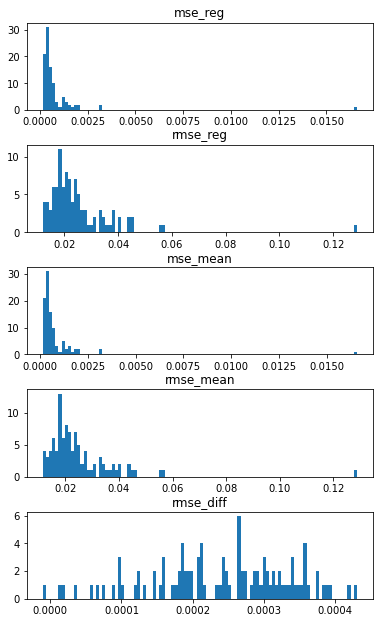

In [9]:
results["rmse_diff"] = results.rmse_reg - results.rmse_mean
draw_distributions(results,5)
plt.subplots_adjust(left=0.1, 
                    bottom=0,  
                    right=0.9,  
                    top=2,  
                    wspace=0.4,  
                    hspace=0.4) 
plt.show()

In [10]:
# window size selection 
# check with window sizes 63/126/189/252: quarterly, every half year, every three quarters, yearly
# see which window size outputs the 'best' results
results_63 = window_size(stocks, 63, LinearRegression)
results_126 = window_size(stocks, 126, LinearRegression)
results_189 = window_size(stocks, 189, LinearRegression)
results_63["rmse_diff"] = results_63.rmse_reg - results_63.rmse_mean
results_126["rmse_diff"] = results_126.rmse_reg - results_126.rmse_mean
results_189["rmse_diff"] = results_189.rmse_reg - results_189.rmse_mean

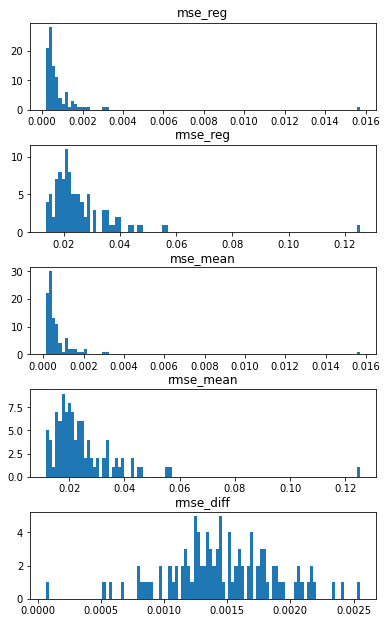

In [11]:
draw_distributions(results_63,5)
plt.subplots_adjust(left=0.1, 
                    bottom=0,  
                    right=0.9,  
                    top=2,  
                    wspace=0.4,  
                    hspace=0.4) 
plt.show()

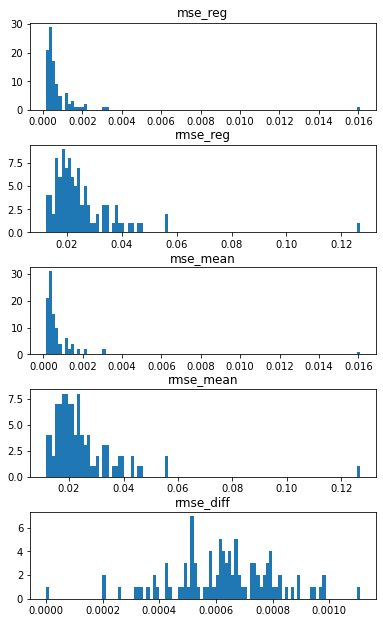

In [12]:
draw_distributions(results_126,5)
plt.subplots_adjust(left=0.1, 
                    bottom=0,  
                    right=0.9,  
                    top=2,  
                    wspace=0.4,  
                    hspace=0.4) 
plt.show()

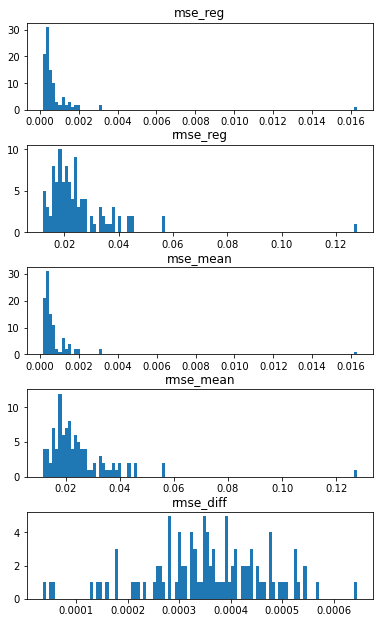

In [13]:
draw_distributions(results_189,5)
plt.subplots_adjust(left=0.1, 
                    bottom=0,  
                    right=0.9,  
                    top=2,  
                    wspace=0.4,  
                    hspace=0.4) 
plt.show()

The historical mean model outperforms the linear regression model for all window sizes. It outperforms the linear regression model the most for smaller window sizes, with the outperformance decreasing the larger the window size gets.

# Create cross section dataset for each stock

In [ ]:
datasets = {}
for company in permno:
    data        = df.loc[df['Permno'] == company]
    competitors = [x for x in permno if x != company]
    competition = pd.DataFrame()
    competition["Dates"] = data.Dates
    
    for competitor in competitors:
        competitor_data = df.loc[df['Permno'] == competitor]
        competition[str(competitor) + '_return_1'] = competitor_data['Return_1']
        
    data['Mrkt_min_return']   = competition.min(axis=1)
    data['Mrkt_max_return']   = competition.max(axis=1)
    data['Mrkt_mean_return']  = competition.mean(axis=1)
    data['Mrkt_median_return']= competition.median(axis=1)
    
    competition = pd.DataFrame()
    competition["Dates"] = data.Dates
    for competitor in competitors:
        competitor_data = df.loc[df['Permno'] == competitor]
        competition[str(competitor) + '_flow_1'] = competitor_data['Flow_1']
    data['Mrkt_min_flow']   = competition.min(axis=1)
    data['Mrkt_max_flow']   = competition.max(axis=1)
    data['Mrkt_mean_flow']  = competition.mean(axis=1)
    data['Mrkt_median_flow']= competition.median(axis=1)
        
    datasets[company]  = data.dropna()

In [15]:
print('Example dataset')
datasets[55976]

Example dataset


,Dates,Permno,Return,Return_1,Return_2,Return_3,Flow_1,Flow_2,Flow_3,Mrkt_min_return,Mrkt_max_return,Mrkt_mean_return,Mrkt_median_return,Mrkt_min_flow,Mrkt_max_flow,Mrkt_mean_flow,Mrkt_median_flow
3,1993-04-06,55976,-0.067227,-0.024590,-0.020080,-0.019685,-5.642141,-6.975709,-4.696503,-0.048780,0.090909,0.003922,0.000000,-25.996274,33.767711,-0.085304,0.220138
4,1993-04-07,55976,0.000000,-0.067227,-0.024590,-0.020080,-6.975709,-5.642141,-6.975709,-0.069767,0.087866,-0.002464,-0.002421,-15.513840,23.276153,0.528329,0.066839
5,1993-04-08,55976,0.040541,0.000000,-0.067227,-0.024590,-6.975709,-6.975709,-5.642141,-0.083333,0.042697,-0.001041,0.000000,-33.738418,19.204137,-0.494283,0.034557
6,1993-04-12,55976,0.038961,0.040541,0.000000,-0.067227,-6.975709,-6.975709,-6.975709,-0.059322,0.069182,-0.000722,0.000000,-21.335603,33.767711,0.232746,0.000000
7,1993-04-13,55976,-0.033333,0.038961,0.040541,0.000000,-3.351631,-6.975709,-6.975709,-0.181818,0.112583,0.009476,0.009259,-13.378146,29.969740,1.489064,0.724427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953,2000-12-22,55976,0.014493,0.057471,0.020781,-0.050680,3.100924,2.088885,1.559735,-0.125000,0.121359,0.009328,0.006821,-21.115301,47.736660,0.555349,-0.212670
1954,2000-12-26,55976,-0.035714,0.014493,0.057471,0.020781,3.519515,3.100924,2.088885,-0.081081,0.151899,0.020474,0.012285,-16.281523,35.551699,1.505990,0.432640
1955,2000-12-27,55976,0.038272,-0.035714,0.014493,0.057471,0.278894,3.519515,3.100924,-0.100000,0.142857,0.004989,0.006211,-17.362388,9.868222,-0.107535,-0.037128
1956,2000-12-28,55976,0.007134,0.038272,-0.035714,0.014493,3.668618,0.278894,3.519515,-0.125000,0.416667,0.023542,0.015432,-29.427942,33.134281,0.181818,0.704297


# Metrics function

In [16]:
def calculate_full_metrics(y_true, y_pred):
    results = []
    results.append(metrics.mean_absolute_error(y_true, y_pred))
    results.append(metrics.max_error(y_true, y_pred))
    results.append(metrics.mean_squared_error(y_true, y_pred))
    results.append(metrics.median_absolute_error(y_true, y_pred))
    results.append(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    results.append(metrics.r2_score(y_true, y_pred))
    return results

# Ridge/Lasso function

In [17]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
def window_ridge_lasso(datasets, w, model,a=1):
    results = pd.DataFrame(columns=['mae', 'max_err','mse','medAE','rmse','r_sqrd'])
    window_length = w
    for company in list(datasets.keys()):
        prediction_list = []
        mean_list = []
        outcome_list = datasets[company].Return[w:]
        for i in range(w, 1955):
            train_feat = features[i-window_length:i]
            train_outcome = outcome[i-window_length:i]
            #historical mean
            mean_list.append(train_outcome.mean())
            
            regressor = model(alpha=a)
            regressor.fit(train_feat,train_outcome)
            # prediction
            y_pred = regressor.predict(features[[i]])
            prediction_list.append(y_pred[0]) 
#     print(prediction_list)
#     print(len(prediction_list))
#     print(outcome_list) # if you do df.iloc[200] you see that the first entry in outcome list is the same as the
#     # return in position 200, so the 2 lists are working
#     print(len(outcome_list))
#     results.loc[len(results)] = calculate_metrics(outcome_list, prediction_list)
        results.loc[len(results)] = calculate_full_metrics(outcome_list, prediction_list)
    return results

# Ridge regression

In [18]:
# alpha selection
best_alpha = 1
best_rmse  = 1000
for a in range(best_alpha,1000,10):
    a_result = window_ridge_lasso(datasets,252,Ridge,a)
    if best_rmse>a_result.rmse.mean():
        best_alpha = a
        best_rmse = a_result.rmse.mean()
print("Best alpha = "+str(best_alpha))

Best alpha = 991


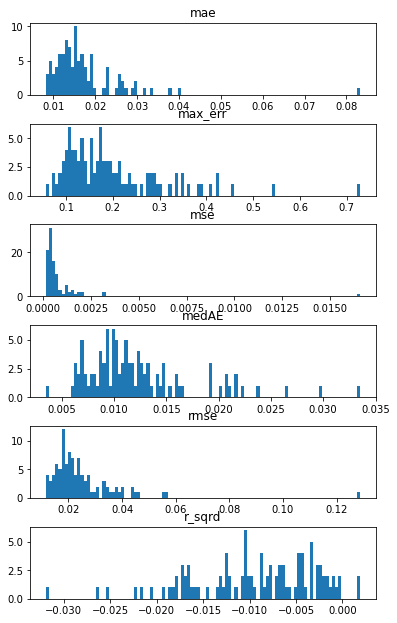

In [19]:
results = window_ridge_lasso(datasets, 252, Ridge, best_alpha) # window size = 252 trading days per year
draw_distributions(results,6)
plt.subplots_adjust(left=0.1, 
                    bottom=0,  
                    right=0.9,  
                    top=2,  
                    wspace=0.4,  
                    hspace=0.4) 
plt.show()

In [20]:
results['rmse'].mean()

0.024935335227239768

# Lasso

In [21]:
# alpha selection
best_alpha = 0.1
best_rmse  = 1000
for a in np.arange(best_alpha,0.2,0.01):
    a_result = window_ridge_lasso(datasets,252,Lasso,a)
    if best_rmse>a_result.rmse.mean():
        best_alpha = a
        best_rmse = a_result.rmse.mean()
print("Best alpha = "+str(best_alpha))

Best alpha = 0.1


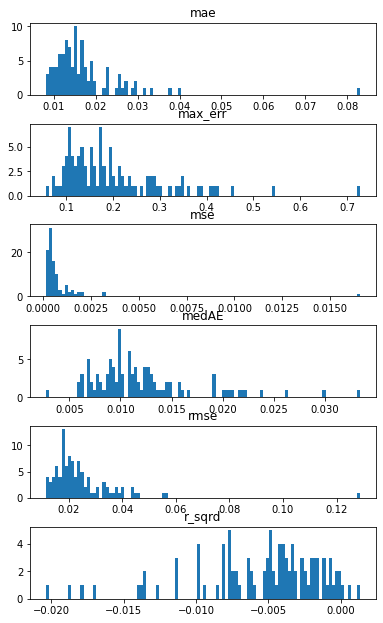

In [22]:
results = window_ridge_lasso(datasets, 252, Lasso, best_alpha) # window size = 252 trading days per year
draw_distributions(results,6)
plt.subplots_adjust(left=0.1, 
                    bottom=0,  
                    right=0.9,  
                    top=2,  
                    wspace=0.4,  
                    hspace=0.4) 
plt.show()

In [23]:
results['rmse'].mean()

0.02489707767266268

# Run and evaluate basic random forest regressor 

In [24]:
def calculate_rfr_metrics(y_true, y_pred):
    results = []
    results.append(metrics.mean_absolute_error(y_true, y_pred))
    results.append(metrics.max_error(y_true, y_pred))
    results.append(metrics.mean_squared_error(y_true, y_pred))
    results.append(metrics.median_absolute_error(y_true, y_pred))
    results.append(metrics.r2_score(y_true, y_pred))
    return results

In [25]:
results = pd.DataFrame(columns=['mae','max_err','mse','medAE','r_sqrd'])
for company in permno:
    data = datasets[company]
    X    = data.iloc[:,3:]
    Y    = data.iloc[:,2]
    X_train, X_test, y_train, y_test = train_test_split(X, Y)
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.loc[len(results)] = calculate_rfr_metrics(y_test,y_pred)


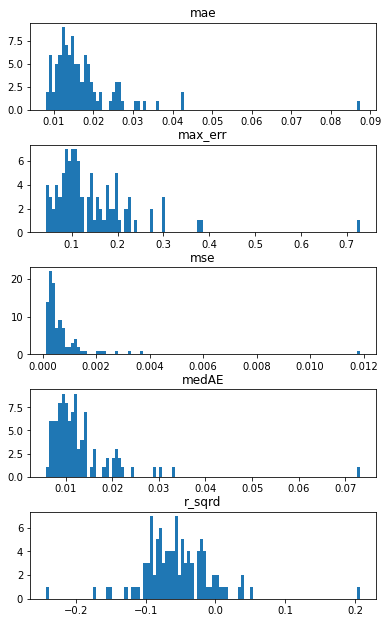

In [26]:
draw_distributions(results, 5)
plt.subplots_adjust(left=0.1, 
                    bottom=0,  
                    right=0.9,  
                    top=2,  
                    wspace=0.4,  
                    hspace=0.4) 
plt.show()

In [27]:
root_rmse = np.sqrt(results['mse']) 
root_rmse.mean()

0.02467441651667539

# Hyperparameter tuning

In [28]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1)
data = datasets[55976]
X    = data.iloc[:,3:]
Y    = data.iloc[:,2]
X_train, X_test, y_train, y_test = train_test_split(X, Y)
rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [29]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10}

# Tuned random forest regressor

In [65]:
results_tuned = pd.DataFrame(columns=['mae','max_err','mse','medAE','r_sqrd'])
for company in permno:
    data = datasets[company]
    X    = data.iloc[:,3:]
    Y    = data.iloc[:,2]
    X_train, X_test, y_train, y_test = train_test_split(X, Y)
    model = RandomForestRegressor(n_estimators=1000,
                                  min_samples_split=5,
                                  min_samples_leaf=2,
                                  max_features='sqrt',
                                  max_depth = 10)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results_tuned.loc[len(results_tuned)] = calculate_rfr_metrics(y_test,y_pred)


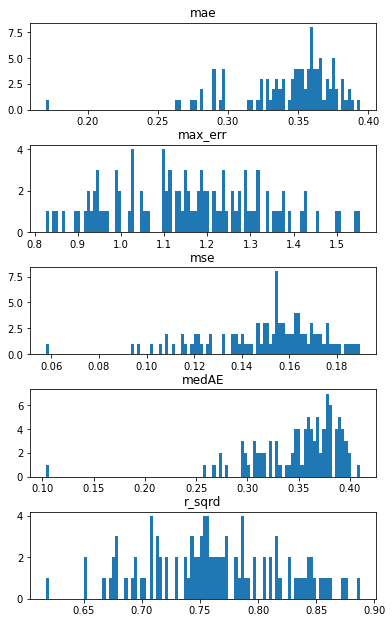

In [66]:
draw_distributions(results_tuned, 5)
plt.subplots_adjust(left=0.1, 
                    bottom=0,  
                    right=0.9,  
                    top=2,  
                    wspace=0.4,  
                    hspace=0.4) 
plt.show()

In [67]:
root_rmse = np.sqrt(results_tuned['mse']) 
root_rmse.mean()

0.3860735610757937

# Classification

##  Data

In [33]:
# define the number of lags
lags = 7

# create an empty data frame with columns dates, permno, returns, and returns/flows number of lags
col_list = ['Dates','Permno','Tertile','Return'] + [f'Return_{x+1}' for x in range(lags)] + [f'Flow_{x+1}' for x in range(lags)] + [f'Tertile_{x+1}' for x in range(lags)]+['Tertile_low','Tertile_high']
df = pd.DataFrame(columns = col_list)

returns['Tertile_low'] = returns.quantile(q=0.33,axis=1,numeric_only=True)
returns['Tertile_high'] = returns.quantile(q=0.66,axis=1,numeric_only=True)
# creates a dataframe of returns/flows and their lags for each company in permno
# print(comp_lags) to visualize
# stacks each dataframe underneath one another and puts it into the empty data dataframe

for company in permno:
    comp_lags = pd.DataFrame(columns = col_list)
    comp_lags['Dates'] = returns['Dates']
    comp_lags['Permno'] = company
    comp_lags['Return'] = returns[company]
    comp_lags['Tertile_low'] = returns['Tertile_low']
    comp_lags['Tertile_high'] = returns['Tertile_high']
    comp_lags['Tertile']= 0
    comp_lags.loc[(comp_lags.Return>comp_lags.Tertile_high),'Tertile']=1
    comp_lags.loc[(comp_lags.Return<comp_lags.Tertile_low),'Tertile']=-1
    
    for i in range(lags):
        comp_lags['Return_'+str(i+1)] = comp_lags['Return'].shift(i+1)
        comp_lags['Flow_'+str(i+1)] = flow[company].shift(i+1)
        comp_lags['Tertile_'+str(i+1)] = comp_lags['Tertile'].shift(i+1)
        
        
    df = pd.concat([df,comp_lags])

# drops the na values from the data dataframe
df = df.dropna()
df

,Dates,Permno,Tertile,Return,Return_1,Return_2,Return_3,Return_4,Return_5,Return_6,...,Flow_7,Tertile_1,Tertile_2,Tertile_3,Tertile_4,Tertile_5,Tertile_6,Tertile_7,Tertile_low,Tertile_high
7,1993-04-13,55976,-1,-0.033333,0.038961,0.040541,0.000000,-0.067227,-0.024590,-0.020080,...,-4.696503,1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.000000,0.009780
8,1993-04-14,55976,-1,-0.060345,-0.033333,0.038961,0.040541,0.000000,-0.067227,-0.024590,...,-6.975709,-1.0,1.0,1.0,0.0,-1.0,-1.0,0.0,-0.004190,0.006452
9,1993-04-15,55976,1,0.013761,-0.060345,-0.033333,0.038961,0.040541,0.000000,-0.067227,...,-5.642141,-1.0,-1.0,1.0,1.0,0.0,-1.0,-1.0,-0.004967,0.006623
10,1993-04-16,55976,-1,-0.036199,0.013761,-0.060345,-0.033333,0.038961,0.040541,0.000000,...,-6.975709,1.0,-1.0,-1.0,1.0,1.0,0.0,-1.0,-0.007786,0.008130
11,1993-04-19,55976,1,0.004695,-0.036199,0.013761,-0.060345,-0.033333,0.038961,0.040541,...,-6.975709,-1.0,1.0,-1.0,-1.0,1.0,1.0,0.0,-0.010530,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953,2000-12-22,48725,1,0.026415,0.037859,-0.030380,0.066127,0.019257,-0.021534,-0.015894,...,0.510598,1.0,-1.0,1.0,0.0,-1.0,0.0,0.0,0.004726,0.025678
1954,2000-12-26,48725,0,0.003676,0.026415,0.037859,-0.030380,0.066127,0.019257,-0.021534,...,3.678821,1.0,1.0,-1.0,1.0,0.0,-1.0,0.0,-0.004169,0.017995
1955,2000-12-27,48725,1,0.028083,0.003676,0.026415,0.037859,-0.030380,0.066127,0.019257,...,-2.376341,0.0,1.0,1.0,-1.0,1.0,0.0,-1.0,0.002180,0.027679
1956,2000-12-28,48725,-1,-0.040380,0.028083,0.003676,0.026415,0.037859,-0.030380,0.066127,...,-1.313592,1.0,0.0,1.0,1.0,-1.0,1.0,0.0,0.001551,0.019841


In [ ]:
datasets = {}
for company in permno:
    data        = df.loc[df['Permno'] == company]
    competitors = [x for x in permno if x != company]
    competition = pd.DataFrame()
    competition["Dates"] = data.Dates
    
    for competitor in competitors:
        competitor_data = df.loc[df['Permno'] == competitor]
        competition[str(competitor) + '_return_1'] = competitor_data['Return_1']
        
    data['Mrkt_min_return']   = competition.min(axis=1)
    data['Mrkt_max_return']   = competition.max(axis=1)
    data['Mrkt_mean_return']  = competition.mean(axis=1)
    data['Mrkt_median_return']= competition.median(axis=1)
    
    competition = pd.DataFrame()
    competition["Dates"] = data.Dates
    for competitor in competitors:
        competitor_data = df.loc[df['Permno'] == competitor]
        competition[str(competitor) + '_flow_1'] = competitor_data['Flow_1']
    data['Mrkt_min_flow']   = competition.min(axis=1)
    data['Mrkt_max_flow']   = competition.max(axis=1)
    data['Mrkt_mean_flow']  = competition.mean(axis=1)
    data['Mrkt_median_flow']= competition.median(axis=1)
        
    datasets[company]  = data.dropna()

In [35]:
print('Example dataset')
datasets[48725]

Example dataset


,Dates,Permno,Tertile,Return,Return_1,Return_2,Return_3,Return_4,Return_5,Return_6,...,Tertile_low,Tertile_high,Mrkt_min_return,Mrkt_max_return,Mrkt_mean_return,Mrkt_median_return,Mrkt_min_flow,Mrkt_max_flow,Mrkt_mean_flow,Mrkt_median_flow
7,1993-04-13,48725,0,0.007678,0.019569,0.001961,0.005917,0.014000,0.026694,-0.010163,...,0.000000,0.009780,-0.181818,0.112583,0.009672,0.009259,-13.378146,29.969740,1.446934,0.696490
8,1993-04-14,48725,-1,-0.007619,0.007678,0.019569,0.001961,0.005917,0.014000,0.026694,...,-0.004190,0.006452,-0.142857,0.059172,0.003215,0.002625,-40.314867,29.844291,0.767072,0.438143
9,1993-04-15,48725,-1,-0.013436,-0.007619,0.007678,0.019569,0.001961,0.005917,0.014000,...,-0.004967,0.006623,-0.060345,0.250000,0.001503,0.000000,-19.291703,21.718050,0.007845,0.326045
10,1993-04-16,48725,1,0.015564,-0.013436,-0.007619,0.007678,0.019569,0.001961,0.005917,...,-0.007786,0.008130,-0.200000,0.081081,-0.000481,0.000000,-17.397389,24.959539,-0.006959,0.000000
11,1993-04-19,48725,-1,-0.015326,0.015564,-0.013436,-0.007619,0.007678,0.019569,0.001961,...,-0.010530,0.000000,-0.043732,0.125000,0.003049,0.000000,-17.756309,32.456094,0.962456,0.222139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953,2000-12-22,48725,1,0.026415,0.037859,-0.030380,0.066127,0.019257,-0.021534,-0.015894,...,0.004726,0.025678,-0.125000,0.121359,0.009526,0.006821,-21.115301,47.736660,0.530418,-0.212670
1954,2000-12-26,48725,0,0.003676,0.026415,0.037859,-0.030380,0.066127,0.019257,-0.021534,...,-0.004169,0.017995,-0.081081,0.151899,0.020353,0.012285,-16.281523,35.551699,1.481599,0.432640
1955,2000-12-27,48725,1,0.028083,0.003676,0.026415,0.037859,-0.030380,0.066127,0.019257,...,0.002180,0.027679,-0.100000,0.142857,0.004591,0.006211,-17.362388,9.868222,-0.091770,0.010884
1956,2000-12-28,48725,-1,-0.040380,0.028083,0.003676,0.026415,0.037859,-0.030380,0.066127,...,0.001551,0.019841,-0.125000,0.416667,0.023645,0.015432,-29.427942,33.134281,0.184239,0.704297


## Classifictation metrics

In [36]:
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score
def evaluate_classification(y_true,y_pred):
    results = []
    results.append(accuracy_score(y_true, y_pred))
    results.append(precision_score(y_true, y_pred,labels=[-1,0,1],average='weighted'))
    results.append(recall_score(y_true, y_pred,labels=[-1,0,1],average='weighted'))
    results.append(f1_score(y_true, y_pred, labels=[-1,0,1],average='weighted'))
    return results
    

## Random Forest Classifier

In [37]:
results = pd.DataFrame(columns=['accuracy','precision','recall','F1-score'])
for company in permno:
    data = datasets[company]
    X    = data.iloc[:,4:]
    Y    = data.iloc[:,2].astype(str).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, Y)
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.loc[len(results)] = evaluate_classification(y_test,y_pred)


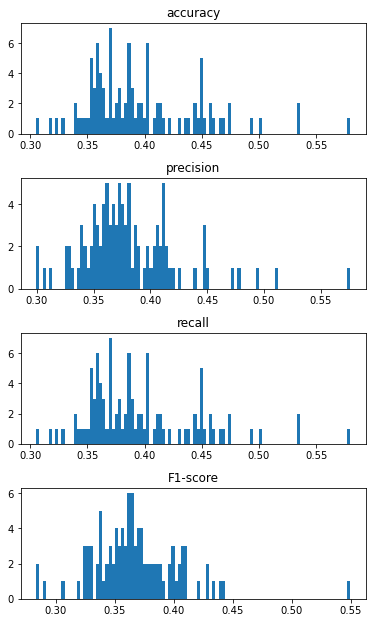

In [38]:
draw_distributions(results, 4)
plt.subplots_adjust(left=0.1, 
                    bottom=0,  
                    right=0.9,  
                    top=2,  
                    wspace=0.4,  
                    hspace=0.4) 
plt.show()

In [39]:
results.accuracy.mean()

0.3964754098360658

## Hyperparameter tuning

In [40]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1)
data = datasets[55976]
X    = data.iloc[:,3:]
Y    = data.iloc[:,2].astype(str).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, Y)
rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [41]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100}

## Tuned Classifier

In [62]:
results_tuned = pd.DataFrame(columns=['accuracy','precision','recall','F1-score'])
for company in permno:
    data = datasets[company]
    X    = data.iloc[:,4:]
    Y    = data.iloc[:,2].astype(str).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, Y)
    model = RandomForestClassifier(n_estimators=1600,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  max_features='auto',
                                  max_depth = 100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results_tuned.loc[len(results_tuned)] = evaluate_classification(y_test,y_pred)


C:\Users\abrit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


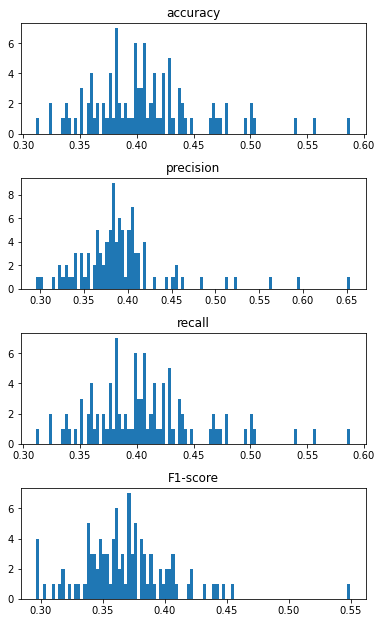

In [63]:
draw_distributions(results_tuned, 4)
plt.subplots_adjust(left=0.1, 
                    bottom=0,  
                    right=0.9,  
                    top=2,  
                    wspace=0.4,  
                    hspace=0.4) 
plt.show()

In [64]:
results_tuned.accuracy.mean()

0.40690573770491795

# Simulation

In [45]:
import random
def make_trade(models, trading_data, day, balance):
    long  = {}
    short = {}
    new_balance = balance
    profit = 0
    longs = 0
    shorts=0
    for company in list(models.keys()):
        company_data         = trading_data[company]
        day_data             = company_data.loc[company_data.index == day]
        returns              = day_data.Return.values[0]
        quintile             = day_data.Quintile.values[0]
        
        if (quintile == 1):
            long[company] = returns
        elif quintile == -1:
            short[company]= returns
            
            
    long_portfolio = random.sample(list(long.values()), min([5,len(long.values())]))
    short_portfolio = random.sample(list(short.values()),min([5,len(short.values())]))
    
    for r in long_portfolio:
        profit = profit + new_balance*(0.1)*r
    for r in short_portfolio:
        profit = profit +new_balance*(0.1)*(-r)
        
        
    new_balance = new_balance+profit
    ret= ((new_balance/balance) -1)
    print("{:.2f}".format(ret)+"%")
    return new_balance, ret

def make_models(datasets, start_of_trading):
    trading_data = {}
    models       = {}
    for company in list(datasets.keys()):
        data          = datasets[company]
        training_data = data.iloc[:start_of_trading,:]
        company_data  = data.iloc[start_of_trading:,:]
        
        features      = training_data.iloc[:,4:]
        labels        = training_data.iloc[:,2].astype(str).astype(int)
        company_model = RandomForestClassifier(n_estimators=1600,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  max_features='auto',
                                  max_depth = 30)
        company_model.fit(features,labels)
        
        data_for_trading= pd.DataFrame()
        data_for_trading["Dates"]   = company_data.Dates
        data_for_trading["Return"]  = company_data.Return
        data_for_trading["Min_quintile_neg"] = company_data.Tertile_low
        data_for_trading["Max_quintile_pos"] = company_data.Tertile_high
        data_for_trading["Quintile"]= company_model.predict(company_data.iloc[:,4:])
        data_for_trading.loc[(data_for_trading.Min_quintile_neg >=0) &(data_for_trading.Quintile == -1), "Quintile"] = 0
        data_for_trading.loc[(data_for_trading.Max_quintile_pos <=0) & (data_for_trading.Quintile == 1), "Quintile"] = 0
        models[company]       = company_model
        trading_data[company] = data_for_trading
    return models, trading_data



In [46]:
#Simulation parameters
#Set starting date of the trading and get the index in dataframe
start_date = pd.to_datetime('1998/01/02',format = '%Y/%m/%d')
dummy_data = datasets[48725]
start_date_index = dummy_data.loc[dummy_data.Dates == start_date].index.values[0]
#Make models
models, trading_data = make_models(datasets, start_date_index)


In [47]:
# Daily trading with 70% investing, 30% cash reserve
balance    = 10000 #starting balance is 100,000$
returns    = []

for i in range(1209, trading_data[55976].index.max()):
    #print("Investing {:.2f}".format(balance*0.7))
    balance,ret = make_trade(models,trading_data, i, balance)
    returns.append(ret)
    print('Trading... Day '+str(i-1209+1)+" Balance:"+"{:.2f}".format(balance))

0.02%
Trading... Day 1 Balance:10198.92
0.01%
Trading... Day 2 Balance:10273.28
-0.00%
Trading... Day 3 Balance:10267.44
-0.00%
Trading... Day 4 Balance:10239.27
-0.01%
Trading... Day 5 Balance:10168.57
0.01%
Trading... Day 6 Balance:10270.17
0.01%
Trading... Day 7 Balance:10419.88
0.01%
Trading... Day 8 Balance:10494.60
0.01%
Trading... Day 9 Balance:10558.79
0.01%
Trading... Day 10 Balance:10709.24
0.01%
Trading... Day 11 Balance:10808.83
0.01%
Trading... Day 12 Balance:10885.14
0.02%
Trading... Day 13 Balance:11052.59
0.01%
Trading... Day 14 Balance:11169.90
0.00%
Trading... Day 15 Balance:11191.29
0.01%
Trading... Day 16 Balance:11294.98
0.01%
Trading... Day 17 Balance:11430.90
-0.00%
Trading... Day 18 Balance:11385.37
0.01%
Trading... Day 19 Balance:11481.45
0.00%
Trading... Day 20 Balance:11505.49
-0.01%
Trading... Day 21 Balance:11361.95
-0.00%
Trading... Day 22 Balance:11357.06
-0.00%
Trading... Day 23 Balance:11333.32
-0.00%
Trading... Day 24 Balance:11318.50
0.01%
Trading... 

0.02%
Trading... Day 201 Balance:26942.81
0.01%
Trading... Day 202 Balance:27103.23
0.00%
Trading... Day 203 Balance:27220.49
-0.00%
Trading... Day 204 Balance:27170.36
-0.00%
Trading... Day 205 Balance:27142.00
0.01%
Trading... Day 206 Balance:27333.82
0.01%
Trading... Day 207 Balance:27542.68
-0.01%
Trading... Day 208 Balance:27249.80
0.01%
Trading... Day 209 Balance:27554.77
0.01%
Trading... Day 210 Balance:27755.41
0.02%
Trading... Day 211 Balance:28250.06
0.00%
Trading... Day 212 Balance:28362.22
0.00%
Trading... Day 213 Balance:28367.42
0.01%
Trading... Day 214 Balance:28513.97
-0.02%
Trading... Day 215 Balance:28058.92
0.00%
Trading... Day 216 Balance:28105.38
-0.02%
Trading... Day 217 Balance:27581.49
0.01%
Trading... Day 218 Balance:27741.69
0.03%
Trading... Day 219 Balance:28678.34
-0.01%
Trading... Day 220 Balance:28435.97
-0.01%
Trading... Day 221 Balance:28134.14
-0.00%
Trading... Day 222 Balance:28129.96
0.01%
Trading... Day 223 Balance:28443.21
-0.00%
Trading... Day 224 

0.00%
Trading... Day 399 Balance:47354.39
0.01%
Trading... Day 400 Balance:47729.62
-0.00%
Trading... Day 401 Balance:47693.29
-0.00%
Trading... Day 402 Balance:47493.54
0.00%
Trading... Day 403 Balance:47576.98
-0.00%
Trading... Day 404 Balance:47571.28
-0.00%
Trading... Day 405 Balance:47535.86
0.01%
Trading... Day 406 Balance:48087.71
0.01%
Trading... Day 407 Balance:48539.33
0.02%
Trading... Day 408 Balance:49413.57
0.01%
Trading... Day 409 Balance:50023.75
-0.00%
Trading... Day 410 Balance:49969.35
0.01%
Trading... Day 411 Balance:50287.96
-0.01%
Trading... Day 412 Balance:50017.88
0.00%
Trading... Day 413 Balance:50193.89
0.00%
Trading... Day 414 Balance:50352.05
0.01%
Trading... Day 415 Balance:51016.64
-0.01%
Trading... Day 416 Balance:50603.30
0.00%
Trading... Day 417 Balance:50634.61
0.00%
Trading... Day 418 Balance:50822.46
0.01%
Trading... Day 419 Balance:51337.11
0.00%
Trading... Day 420 Balance:51487.48
0.00%
Trading... Day 421 Balance:51541.05
-0.00%
Trading... Day 422 B

0.01%
Trading... Day 598 Balance:113262.91
-0.01%
Trading... Day 599 Balance:112679.38
0.00%
Trading... Day 600 Balance:112803.22
0.00%
Trading... Day 601 Balance:112970.41
0.02%
Trading... Day 602 Balance:115259.97
-0.01%
Trading... Day 603 Balance:113926.78
0.02%
Trading... Day 604 Balance:116385.47
0.01%
Trading... Day 605 Balance:117509.18
-0.01%
Trading... Day 606 Balance:115968.08
0.01%
Trading... Day 607 Balance:116573.93
0.01%
Trading... Day 608 Balance:117883.30
-0.00%
Trading... Day 609 Balance:117596.72
0.01%
Trading... Day 610 Balance:118805.36
0.02%
Trading... Day 611 Balance:120691.93
0.01%
Trading... Day 612 Balance:121373.62
-0.01%
Trading... Day 613 Balance:120358.26
-0.00%
Trading... Day 614 Balance:119916.91
0.01%
Trading... Day 615 Balance:120650.66
-0.01%
Trading... Day 616 Balance:119336.33
0.01%
Trading... Day 617 Balance:120272.99
0.00%
Trading... Day 618 Balance:120320.58
0.00%
Trading... Day 619 Balance:120560.19
-0.01%
Trading... Day 620 Balance:119183.99
-0.

In [48]:
trading_data[55976]

,Dates,Return,Min_quintile_neg,Max_quintile_pos,Quintile
1209,1998-01-13,0.000000,0.000000,0.014793,1
1210,1998-01-14,0.004747,0.000000,0.012469,0
1211,1998-01-15,0.006299,-0.006285,0.004065,-1
1212,1998-01-16,0.004695,0.002906,0.018583,0
1213,1998-01-20,0.040498,0.000000,0.019374,0
...,...,...,...,...,...
1953,2000-12-22,0.014493,0.004726,0.025678,1
1954,2000-12-26,-0.035714,-0.004169,0.017995,0
1955,2000-12-27,0.038272,0.002180,0.027679,1
1956,2000-12-28,0.007134,0.001551,0.019841,0


## Graph of the simulation (Comparison to S&P500)

In [52]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
sp500 = pd.read_csv('./SP500.csv')
sp500.date = pd.to_datetime(sp500.date, format = '%Y%m%d')
sp500['return'] = sp500['return'] 
sp500 = sp500.loc[sp500.date.isin(trading_data[55976].Dates)]
sp500 = sp500.rename(columns={'return':'SP500'})
sp500 = sp500.iloc[1:,:]
sp500['Simulation'] = returns
sp500 = sp500.drop(columns=['secid'])
sp500 = sp500.set_index('date')

In [53]:
cum_returns=np.cumprod(np.array(returns)+1)-1

In [54]:
len(returns), len(sp500), len(cum_returns)

(748, 748, 748)

In [55]:
sp500['Sim_cum_return'] = cum_returns

sp500['SP500_cum_return']= np.cumprod(np.array(sp500.SP500.values)+1)-1
len(sp500.loc[sp500.SP500>0]),len(sp500.loc[sp500.Simulation>0])

(385, 518)

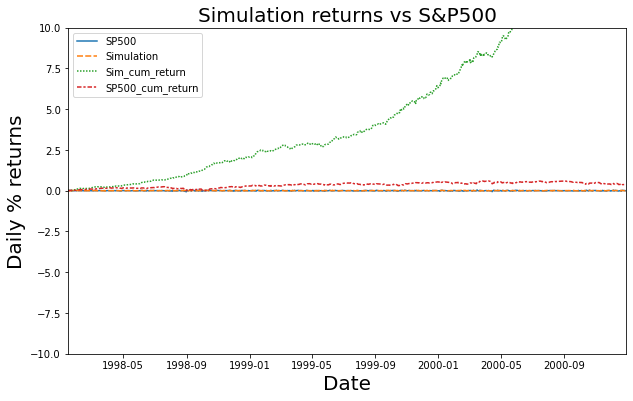

In [56]:
from IPython.display import HTML
title = 'Simulation returns vs S&P500'

fig = plt.figure(figsize=(10,6))
plt.xlim(sp500.index.min(), sp500.index.max())
plt.ylim(-10, 10)


plt.xlabel('Date',fontsize=20)
plt.ylabel('Daily % returns',fontsize=20)
plt.title(title,fontsize=20)

p = sns.lineplot(data=sp500)


plt.show()

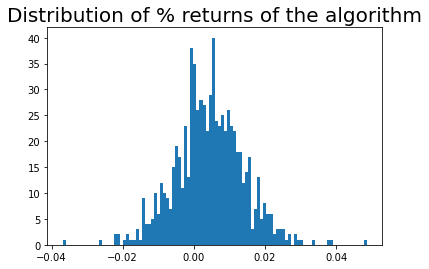

In [57]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(list(sp500.Simulation.values), bins = 100)
plt.title("Distribution of % returns of the algorithm",fontsize=20)
plt.show()

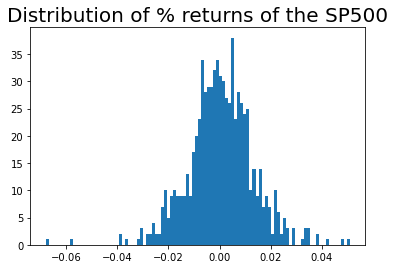

In [58]:
fig = plt.figure()
plt.hist(list(sp500.SP500.values), bins = 100)
plt.title("Distribution of % returns of the SP500",fontsize=20)
plt.show()

Graph price movements

In [59]:
sp500 = pd.read_csv('./SP500_prices.csv')
sp500.date = pd.to_datetime(sp500.date, format = '%Y%m%d')
sp500 = sp500.loc[sp500.date.isin(trading_data[55976].Dates)]
sp500 = sp500.rename(columns={'close':'SP500'})
sp500 = sp500.drop(columns=['secid'])
sp500 = sp500.set_index('date')
sp500

,SP500
date,
1998-01-13,952.12
1998-01-14,957.94
1998-01-15,950.73
1998-01-16,961.51
1998-01-20,978.60
...,...
2000-12-22,1305.97
2000-12-26,1315.19
2000-12-27,1328.92


In [60]:
# Daily trading with 70% investing, 30% cash reserve
balance    = sp500.SP500.iloc[0] #starting balance is 100,000$
balances   = [balance]

for i in range(1209, trading_data[55976].index.max()):
    #print("Investing {:.2f}".format(balance*0.7))
    balance,ret = make_trade(models,trading_data, i, balance)
    balances.append(balance)
    print('Trading... Day '+str(i-1209+1)+" Balance:"+"{:.2f}".format(balance))

sp500['Simulation'] = balances
sp500

0.02%
Trading... Day 1 Balance:967.81
0.01%
Trading... Day 2 Balance:977.83
0.01%
Trading... Day 3 Balance:982.87
-0.00%
Trading... Day 4 Balance:981.92
0.00%
Trading... Day 5 Balance:983.83
-0.00%
Trading... Day 6 Balance:982.64
0.01%
Trading... Day 7 Balance:994.99
0.00%
Trading... Day 8 Balance:999.23
0.01%
Trading... Day 9 Balance:1004.62
0.00%
Trading... Day 10 Balance:1006.25
0.01%
Trading... Day 11 Balance:1014.90
-0.00%
Trading... Day 12 Balance:1014.77
0.00%
Trading... Day 13 Balance:1016.61
0.00%
Trading... Day 14 Balance:1017.26
0.01%
Trading... Day 15 Balance:1026.55
0.00%
Trading... Day 16 Balance:1030.07
0.01%
Trading... Day 17 Balance:1043.61
0.00%
Trading... Day 18 Balance:1043.79
-0.01%
Trading... Day 19 Balance:1037.47
0.01%
Trading... Day 20 Balance:1052.80
0.00%
Trading... Day 21 Balance:1055.14
-0.01%
Trading... Day 22 Balance:1049.66
0.00%
Trading... Day 23 Balance:1053.20
0.00%
Trading... Day 24 Balance:1055.02
0.00%
Trading... Day 25 Balance:1058.51
0.01%
Tradin

0.01%
Trading... Day 207 Balance:2929.57
-0.00%
Trading... Day 208 Balance:2921.82
0.01%
Trading... Day 209 Balance:2950.96
0.00%
Trading... Day 210 Balance:2963.89
0.02%
Trading... Day 211 Balance:3019.94
-0.00%
Trading... Day 212 Balance:3005.95
0.00%
Trading... Day 213 Balance:3009.68
0.00%
Trading... Day 214 Balance:3018.03
-0.03%
Trading... Day 215 Balance:2941.88
-0.01%
Trading... Day 216 Balance:2904.29
0.01%
Trading... Day 217 Balance:2925.30
0.00%
Trading... Day 218 Balance:2932.98
0.00%
Trading... Day 219 Balance:2933.81
0.01%
Trading... Day 220 Balance:2960.96
-0.01%
Trading... Day 221 Balance:2944.79
0.01%
Trading... Day 222 Balance:2967.26
0.02%
Trading... Day 223 Balance:3014.22
0.00%
Trading... Day 224 Balance:3022.70
0.01%
Trading... Day 225 Balance:3042.98
-0.01%
Trading... Day 226 Balance:3015.82
0.02%
Trading... Day 227 Balance:3061.18
0.00%
Trading... Day 228 Balance:3075.66
-0.00%
Trading... Day 229 Balance:3071.86
0.02%
Trading... Day 230 Balance:3122.24
0.00%
Tra

0.00%
Trading... Day 407 Balance:5963.59
0.01%
Trading... Day 408 Balance:6002.61
0.00%
Trading... Day 409 Balance:6027.37
0.01%
Trading... Day 410 Balance:6069.11
0.01%
Trading... Day 411 Balance:6125.24
0.00%
Trading... Day 412 Balance:6155.79
0.00%
Trading... Day 413 Balance:6173.47
0.01%
Trading... Day 414 Balance:6204.61
0.01%
Trading... Day 415 Balance:6259.32
0.01%
Trading... Day 416 Balance:6334.72
0.00%
Trading... Day 417 Balance:6355.13
-0.01%
Trading... Day 418 Balance:6310.65
0.01%
Trading... Day 419 Balance:6400.08
0.01%
Trading... Day 420 Balance:6491.20
-0.01%
Trading... Day 421 Balance:6441.56
-0.00%
Trading... Day 422 Balance:6421.04
0.01%
Trading... Day 423 Balance:6463.92
0.01%
Trading... Day 424 Balance:6536.77
0.01%
Trading... Day 425 Balance:6580.41
0.00%
Trading... Day 426 Balance:6599.01
0.01%
Trading... Day 427 Balance:6693.42
0.00%
Trading... Day 428 Balance:6725.63
0.00%
Trading... Day 429 Balance:6737.99
0.00%
Trading... Day 430 Balance:6739.09
0.02%
Trading

0.00%
Trading... Day 611 Balance:11468.36
-0.01%
Trading... Day 612 Balance:11383.31
-0.00%
Trading... Day 613 Balance:11369.90
-0.00%
Trading... Day 614 Balance:11355.50
0.01%
Trading... Day 615 Balance:11429.13
0.00%
Trading... Day 616 Balance:11461.26
-0.01%
Trading... Day 617 Balance:11352.60
0.01%
Trading... Day 618 Balance:11427.88
-0.01%
Trading... Day 619 Balance:11355.33
-0.01%
Trading... Day 620 Balance:11289.58
0.01%
Trading... Day 621 Balance:11356.86
0.00%
Trading... Day 622 Balance:11393.90
0.01%
Trading... Day 623 Balance:11501.13
-0.01%
Trading... Day 624 Balance:11343.50
0.01%
Trading... Day 625 Balance:11426.41
-0.01%
Trading... Day 626 Balance:11266.96
-0.01%
Trading... Day 627 Balance:11150.76
-0.00%
Trading... Day 628 Balance:11136.57
0.02%
Trading... Day 629 Balance:11346.55
-0.00%
Trading... Day 630 Balance:11301.22
-0.03%
Trading... Day 631 Balance:11017.25
0.00%
Trading... Day 632 Balance:11053.18
-0.01%
Trading... Day 633 Balance:10963.88
0.00%
Trading... Day 

,SP500,Simulation
date,,
1998-01-13,952.12,952.120000
1998-01-14,957.94,967.812747
1998-01-15,950.73,977.825350
1998-01-16,961.51,982.873080
1998-01-20,978.60,981.919104
...,...,...
2000-12-22,1305.97,16224.925451
2000-12-26,1315.19,16471.279852
2000-12-27,1328.92,16552.791274


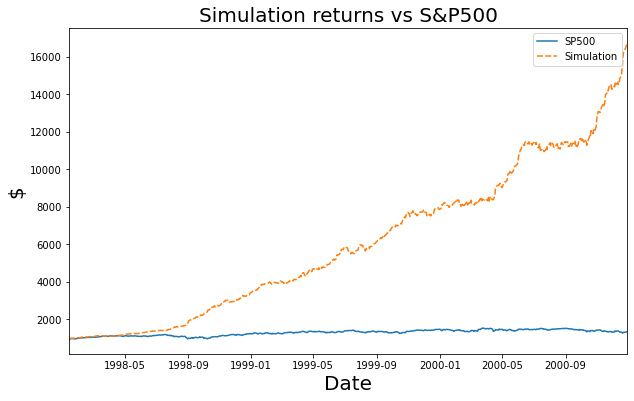

In [61]:
title = 'Simulation returns vs S&P500'

fig = plt.figure(figsize=(10,6))
plt.xlim(sp500.index.min(), sp500.index.max())


plt.xlabel('Date',fontsize=20)
plt.ylabel('$',fontsize=20)
plt.title(title,fontsize=20)

p = sns.lineplot(data=sp500)


plt.show()